# **Plant Health Check**

# **CNN Project**

**Author:-** 

**Hrishkesh Sandeep Nagle**

*University of Connecticut, MS Business Analytics and Project Management*

This project was undertaken as a part of an academic assessment for Deep Learning course under the supervision of :-

**David Wanik, Assistant Professor in-Residence at University of Connecticut**.



# **Introduction**

The COVID-19 pandemic has increased the time people spend indoors. A large population of Millennials have started growing house plants as a recreational activity. According to the National Gardening Association, the sales of house plants have doubled over the last three years. As planting is such a lucrative industry, novice plant owners may not fully care for the plants. To encourage the better health of their plants and prevent the risk of leading to an unhealthy condition, I will try to build a classification model that would predict the health of the plants and further integrate it with a camera interface to monitor health in real time. This will be a two part project where I will first train a Convolutional Neural Network to perform classification on our data, and then in the second part I will integrate this with webcameras and Android cameras


<image src="https://www.kellogggarden.com/wp-content/uploads/2020/05/take-photo-of-plants.jpg" height="400">

## **Business Problem**

>The aim here is to predict if the plant requires treatment or not. From the perspective of mdel building, we want to classify unhealthy house-plants from  healthy house plants. By using this classification, we want to help novice plant owners to take care of their plants. This can be further built to identify what condition the plant is affected by and develop a prescription analytics use case.

# **Let's Begin with Data Collection**

**Note:-**
This model was trained on google colab. This will require us to mount out drive first before proceeding to our data extraction and modeling

In [3]:
# mount google drive
from google.colab import drive, files
drive.mount('/content/drive/')


Mounted at /content/drive/


# **Import All Modules**

In [4]:
import keras
keras.__version__

'2.8.0'

In [ ]:
# Packages for Data Extraction
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin


from google.colab import files
import sys
from selenium import webdriver
from google_images_download import google_images_download  
import shutil


In [5]:
import os
import time
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from keras.preprocessing import image
from keras import callbacks
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

# **Data Extraction**

To tackle this business problem, I will be scraping images from google to create my own dataset. We will need two classes of images - unhealthy plants and healthy plants. The following is a web-scraping script provided thanks to my professor. We need to use keywords such as “Unhealthy Houseplants" or "Dead Houseplants" to create a directory of **Un-healthy houseplants** and used keywords such as "Healthy Houseplants” or "Healthy plants" to create a directory for **Healthy plants**.

I am uploading a zip file with all the data that has been used for training the model if you would like to try building your own architecture!

_Following are few images from my database:-_

<image src="https://smartgardenguide.com/wp-content/uploads/2021/04/overwatering-vs-underwatering-2.jpg" height="400">


## **Web Scraping**

In [ ]:
! git clone https://github.com/Joeclinton1/google-images-download.git

In [ ]:
cd google-images-download

In [ ]:
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')


options = webdriver.ChromeOptions()

# set options to be headless, ..
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',options=options)
wd.get("https://stackoverflow.com/questions/51046454/how-can-we-use-selenium-webdriver-in-colab-research-google-com")
wd.title

In [ ]:
# Change the keyword to download images

response = google_images_download.googleimagesdownload()   #class instantiation

arguments = {"keywords":"Healthy Houseplants","limit":600,
             "print_urls":True,
              "chromedriver": "/usr/bin/chromedriver"
             }   #creating list of arguments
paths = response.download(arguments)   #passing the arguments to the function
print(paths)   #printing absolute paths of the downloaded images

In [ ]:
# remember to change the path to make it work, delete any preexisting folders with same name
shutil.move("/content/google-images-download/google-images-download/downloads/Healthy Houseplants", "/content/drive/MyDrive/Paste_your_path/Data/Healthy Houseplants")


_**Repeat the same for Unhealthy houseplants**_

_**Important Note**_

>The above script will directly scrape images pertaining to the given keyword. This means your data might have images that will not be relevant or helpful for model building process. For example caricature or paintings of images. For practical purposes we will want to get rid of these manually for real-life application of our model!

# **Creating Custom Functions**

I will be creating helper functions that will simplify repeated tasks such as data cleaning and model evaluation which will be discussed ahead  

## **Rename and Convert Images to JPG**

The for the purpose of reading our images and converting them to numpy arrays for the model to understand we will need them to be in the .jpg format. The following function will achieve this.

In [ ]:
## Function to rename files

def rename_files(dir_list):

  ''''
  This function will attempt to do the following
  
  For each directory in dir_list
  1) Move files to Final directory
  2) Rename them
  3) Convert all to .jpg

  While writting over to new directory, we will first delete all files at the destination,
  so that there are no duplicate names. 
  
  Final destination will have suffix '_Final'

  '''
  ## Binary classes
  plant_condition = ['Healthy','Unhealthy']

  ## Select a directory from the list
  for directory in dir_list:
    for condition in plant_condition:
      ## Make source and destination paths 
      dir_from = directory + '/' + condition + '/'
      dir_to = directory + '_Final/' + condition + '/'
      
      ## Empty destination folder
      for filename in os.listdir(dir_to):
        os.remove(os.path.join(dir_to,filename))

      ## Initiate loop to rename files to destination
      i = 1
      for filename in os.listdir(dir_from):
          prefix = condition + '_' + str(i) + ".jpg"  
          os.rename(os.path.join(dir_from,filename) , os.path.join(dir_to,prefix))
          i+=1

## **Printing Partition Size**

Once we have our data cleaned, we will want to print the size of our directories to double check if everything adds up

In [ ]:
## Creating a function to print folder sizes
def print_size(dir_list):

  ''''
  This Function will attempt to:  
  1) Print the number of images in all directories 
  2) Total split of Train, Test and Validation
  '''
  
  for dir in dir_list:
    print(os.path.split(dir)[1],'\n','Healthy:',len(os.listdir(dir + '/Healthy/')),'\t','Unhealthy:',len(os.listdir(dir+ '/Unhealthy/')))
    print(os.path.split(dir)[1] + ' split:',len(os.listdir(dir + '/Healthy/')) + len(os.listdir(dir+ '/Unhealthy/')),'\n')

## **Learning Curves**

Plots for the learning curves while training the model

In [ ]:
## Plotting Learing curves
def learning_curves(hist):

  ''''
  We will plot all the learning curves using our own function

  Using Seaborn for pretty graphs
  '''
  
  ## Store accuracy and loss from the history object as dataframes for seaborn line plots
  acc = pd.DataFrame({'Training Acc' : hist.history['acc'],
                    'Validation Acc' : hist.history['val_acc']})

  loss = pd.DataFrame({'Training Loss' : hist.history['loss'],
                    'Validation Loss' : hist.history['val_loss']})

  # Get the number of epochs
  epochs = range(len(acc))


  # Plot accuracy
  sns.relplot(data=acc,
              kind = 'line',
              palette = "inferno_r",
              aspect = 2)
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Training and Validation accuracy")
  plt.xticks(epochs)

  plt.figure(1)

  # Plot Loss
  sns.relplot(data=loss,
              kind='line',
              palette = "inferno_r",
              aspect=2)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training and Validation Loss")
  plt.xticks(epochs)

  plt.show()




## **Confusion Matrix and Evaluation Report**

Visualize model evaluation metrics to gauge its performance

In [ ]:
## Printing confusion Matrix and Evaluation report 
def evaluation_metric_gen(model,test_gen):

  ''''
  
  This function will calculate the Confusion matrix as well as other fit statistic

  Again, we will leverage seaborn for this.

  '''
  # Predict our classes using our model
  pred_classes = model.predict(test_gen)

  # Convert them to 0 and 1, if more than 2 classes user argmax
  pred_classes = np.round(pred_classes,0)

  # Get true labels from test data
  true_classes = test_gen.classes
  class_labels = list(test_gen.class_indices.keys()) 

  # Make confusion matrix
  cf_matrix = confusion_matrix(true_classes, pred_classes)

  # Names for prediction classes
  group_names = ['True Neg','False Pos','False Neg','True Pos']

  # get count in each class
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]

  # get percentage of each class
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

  # merge class,count and percentage
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(2,2)

  # Plot Confusion matrix as a heatmat
  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

  ax.set_title('Confusion Matrix\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['Healthy','Unhealthy'])
  ax.yaxis.set_ticklabels(['Healthy','Unhealthy'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

  # Print evaluation Report
  report = classification_report(true_classes, pred_classes, target_names=class_labels)
  print('\n',report)    


 

# **Partition Data**

After scarping the images, I have 1,000 images of healthy and unhealthy house plants (500 from each class). These sit in a separate directory from the one I will be using to build our model to have a back up. I have manually split the data into 3 folders of Train, Validation and Test, each with 2 sub folders for Healthy and Unhealthy houseplants. Thus 700 images in total for Training, 200 samples for Validation, and a Test folder with 100 samples. With these, we will be using the rename helper function to read and write the images to our Final folder. The following code will set up these directories

_**Note:-**_

I have used a small data set to train the model but this will not be a big problem as I will be leveraging Data Augmentation and Transfer Learning. Both of these concepts are explained further in this file.

In [1]:
## Creating Path for each directory 
path = "/content/drive/Shareddrives/Deep Learning Team Project/CNN/Data/" 
train_tmp = path + "Train"
validation_tmp = path + "Validation"
test_tmp = path + "Test"

train_dir = train_tmp + '_Final'
validation_dir = validation_tmp + '_Final'
test_dir = test_tmp + '_Final'

In [2]:
## Store them as a list to reference in loops
directories = [train_tmp,validation_tmp,test_tmp]

## Directories for processed data
final_directories = [train_dir,validation_dir,test_dir]

# **Running our custom functions on Partitioned Data**

## **_Important Note_**

> **_Run The Next Block Only Once For Renaming Files_**

We will be renaming all images such that there are no duplicate names. Additionally, we converted all images into .jpg as .jpg file is compatible with python. 

In [ ]:
# Rename and convert all files
rename_files(directories)

In [ ]:
# Print to reconfirm sizes
print_size(final_directories)

Train_Final 
 Healthy: 350 	 Unhealthy: 350
Train_Final split: 700 

Validation_Final 
 Healthy: 100 	 Unhealthy: 100
Validation_Final split: 200 

Test_Final 
 Healthy: 50 	 Unhealthy: 50
Test_Final split: 100 



>**As You can see, we have split our data into:-**

* Train - 700
* Validation - 200
* Test - 100

# **Viewing Our Data**

Before building any machine learning model, one should always check what kind of data they are dealing with. For this, lets try to print our images

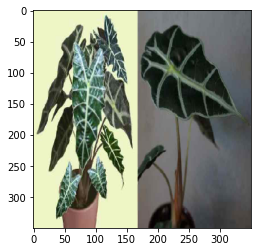

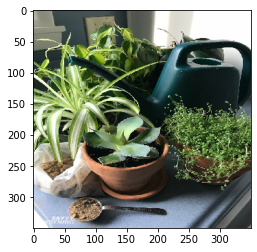

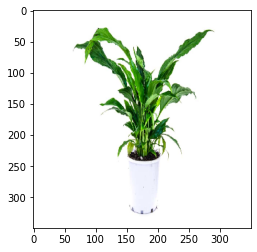

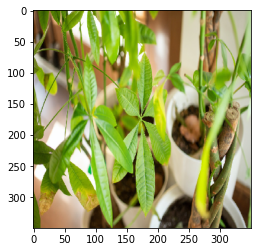

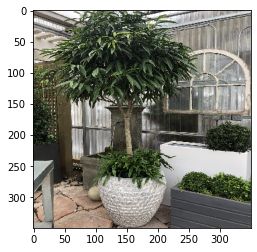

In [ ]:
## Lets see our images before running any models
for i in range(1,6):
  string = (train_dir, '/Healthy/Healthy_',str(i),'.jpg')
  s = ''
  img_path = s.join(string)
  img = image.load_img(img_path, target_size=(350, 350))
  plt.figure(i)
  imgplot = plt.imshow(img)

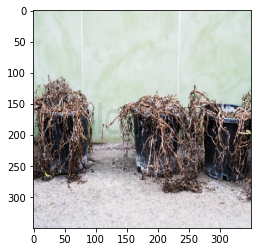

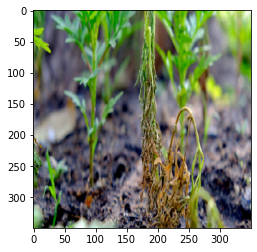

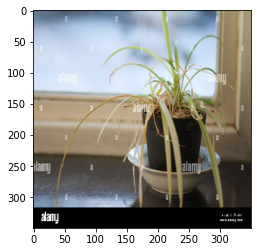

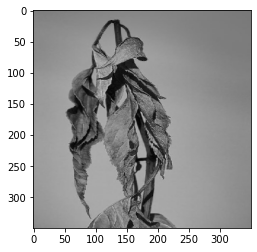

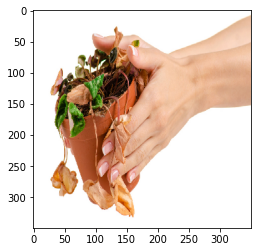

In [ ]:
## Same for Unhealthy
for i in range(1,6):
  string = (train_dir, '/Unhealthy/Unhealthy_',str(i),'.jpg')
  s = ''
  img_path = s.join(string)
  img = image.load_img(img_path, target_size=(350, 350))
  plt.figure(i)
  imgplot = plt.imshow(img)


**To Remove Duplicates**

Data duplication would lead to model overfitting on our training data. For this we need to clean any duplicate images and for the scope of this project we will manually delete duplicate images

One could look at the following code by Elise Landman for automated cleaning.

>Link: https://towardsdatascience.com/finding-duplicate-images-with-python-71c04ec8051

# **CNN baseline model**

<image src="https://miro.medium.com/max/1400/1*vkQ0hXDaQv57sALXAJquxA.jpeg" height="400">



 Convolutional Neural Networkss are a class of neural networks that are suited for use cases where the topology of our data is like grids or matrices. For example Image data, where each image is stored as individual pixel stacked over one another. 

 The name Convolution comes from the fact that these models convolve and transform our input by applying small tensors(small grid of numbers which identifies different shapes and textures) to generate different feature maps. This convolution is a simple matrix dot product of our input and our tensor which acts like automated feature engineering. This is one reason why CNN's do not require rigorous data procesing 
 
 The Reason why CNN's are gaining popularity is that we only need to update our tensors through Back Propagation and Gradient Decent, which could be just 100 tensors of size 3x3(thus only close to 1000 parameters) to solve even a complex problems like detection of cancerous cells from MRI images. On the other hand, a dense network would require 500 Million parameters for the same problem with a standard image and 1 layer with 256 nodes. 

## **Data preprocessing**

Before building the architecture of the model, we need to rescale the images such that all images are of same size and are formatted into appropriately pre-processed floating point tensors before being fed into our network.Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval.

For the baseline model, we have re-sized the image to 150x150 pixels. 

In [ ]:
# All images will be rescaled by 1./255
train_datagen_1 = ImageDataGenerator(rescale=1./255)
test_datagen_1 = ImageDataGenerator(rescale=1./255)


train_generator_1 = train_datagen_1.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=5,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


validation_generator_1 = test_datagen_1.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=5,
        class_mode='binary')


test_generator_1 = test_datagen_1.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=5,
        class_mode='binary')

Found 700 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


## **Architecture**

For the baseline, I will define a pretty straightforward netword starting with 64 filters and 

In [6]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3))) # this needs to match with our data prep - upcoming!
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(512, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))

>Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [7]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## **Compile**

In [ ]:
model_1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

## **Fit Model**

While fitting the model, I have used earlystopping so that the model stops training once the model performance stops improving on a hold out validation dataset.

In [ ]:
# Create a callback object
es = EarlyStopping(monitor='val_acc', mode='max', 
                   patience=10, 
                   verbose=1,
                   restore_best_weights=True)

# Fit the model on our data
history_1 = model_1.fit(
      train_generator_1,
      steps_per_epoch=70,  # this is total training samples / batch size chosen, 700/10
      epochs=100,          # the number times that the learning algorithm will work through the entire training dataset
      validation_data=validation_generator_1,
      validation_steps=20, # 200/10
      callbacks= [es])

Epoch 1/100
70/70 [==============================] - 73s 1s/step - loss: 0.6977 - acc: 0.5057 - val_loss: 0.6911 - val_acc: 0.4800
Epoch 2/100
70/70 [==============================] - 41s 580ms/step - loss: 0.6480 - acc: 0.5943 - val_loss: 0.6282 - val_acc: 0.5600
Epoch 3/100
70/70 [==============================] - 45s 646ms/step - loss: 0.6672 - acc: 0.6686 - val_loss: 0.6660 - val_acc: 0.6800
Epoch 4/100
70/70 [==============================] - 24s 353ms/step - loss: 0.5898 - acc: 0.6886 - val_loss: 0.6340 - val_acc: 0.6800
Epoch 5/100
70/70 [==============================] - 20s 290ms/step - loss: 0.4786 - acc: 0.8000 - val_loss: 0.5142 - val_acc: 0.6800
Epoch 6/100
70/70 [==============================] - 18s 260ms/step - loss: 0.4601 - acc: 0.8114 - val_loss: 0.4419 - val_acc: 0.8000
Epoch 7/100
70/70 [==============================] - 15s 223ms/step - loss: 0.4664 - acc: 0.7943 - val_loss: 0.4454 - val_acc: 0.8000
Epoch 8/100
70/70 [==============================] - 14s 206ms/st

## **Evaluation Metrics**

### **Learning Curves**

Let's plot the loss and accuracy of the model over the training and validation data during training:

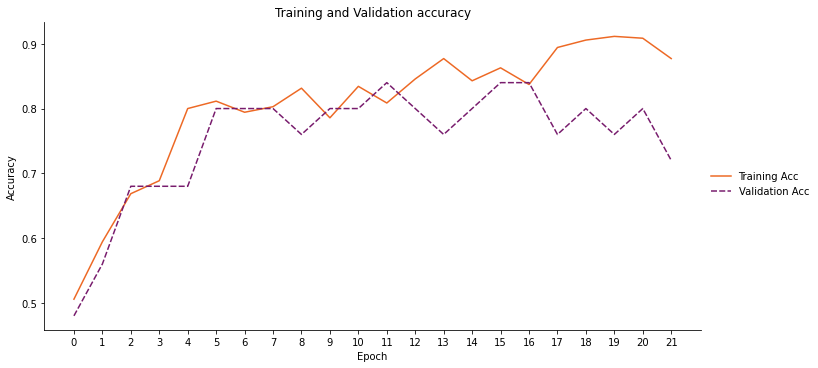

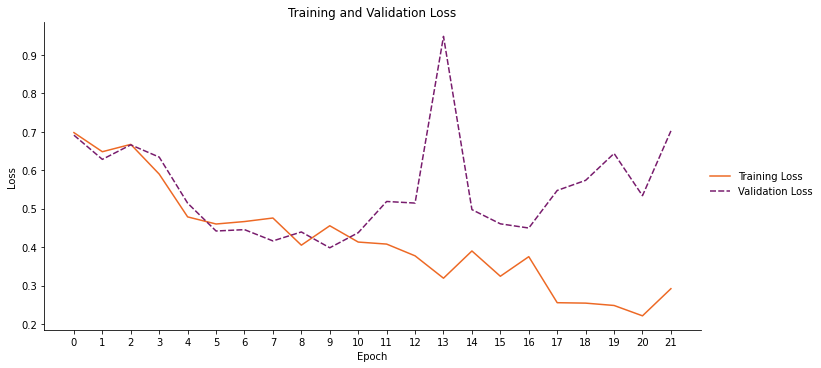

In [ ]:
learning_curves(history_1)

### **Confusion Matrix**

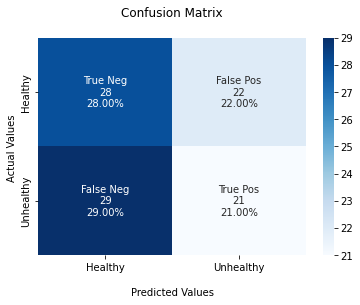


               precision    recall  f1-score   support

     Healthy       0.49      0.56      0.52        50
   Unhealthy       0.49      0.42      0.45        50

    accuracy                           0.49       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.49      0.49      0.49       100



In [ ]:
evaluation_metric_gen(model_1,test_generator_1)

> As seen above, the recall for Unhealthy houseplants is very low(0.42). This basically means this model is only able to classify 42% of the unhealthy images correctly. This is not good from our objectives perspective as this would imply our users not treating their plants when in reality they should and thus run the risk of losing their plants. We will try to improve over this by using a pre-trained model! 

In [ ]:
test_loss_1, test_acc_1 = model_1.evaluate(test_generator_1, steps=10)
test_acc_1 = round(test_acc_1,5)
val_acc_1  = round(max(history_1.history['val_acc']),5)

10/10 [==============================] - 1s 149ms/step - loss: 0.3981 - acc: 0.8200


In [ ]:
print('Validation Accuracy: %s  \nTest Accuracy: %s' % (val_acc_1,test_acc_1))

Validation Accuracy: 0.84  
Test Accuracy: 0.82


# **Leveraging Pre-trained models**

**Transfer Learning/ feature Extraction**

As we know, machine learning and deep learning models perform better when they are trained on as many data points as possible. The notion here is that for a small dataset, we can leverage a ConvNet that has already been trained on larger datasets and has learnt spatial features as well as texture, and build a model which can generalise well even with limited data

For this project I will try the MobileNetV2 model as this model was trained keeping the processing power of mobiles in mind. The aim is to allow people to use this model at their home to check their plants health. With this in mind, it is infinitely more practical to train a model that can be supported on a hand held device rather than a computer or laptop  


### **MobileNetV2**

 MobileNetV2 is a next generation mobile vision application which is a significant improvement over MobileNetV1 and pushes the state of the art for mobile visual recognition including classification, object detection and semantic segmentation. MobileNetV2 is released as part of TensorFlow-Slim Image Classification Library

 >Link:- MobileNetV2: Inverted Residuals and Linear Bottlenecks (CVPR 2018)
* https://arxiv.org/abs/1801.04381

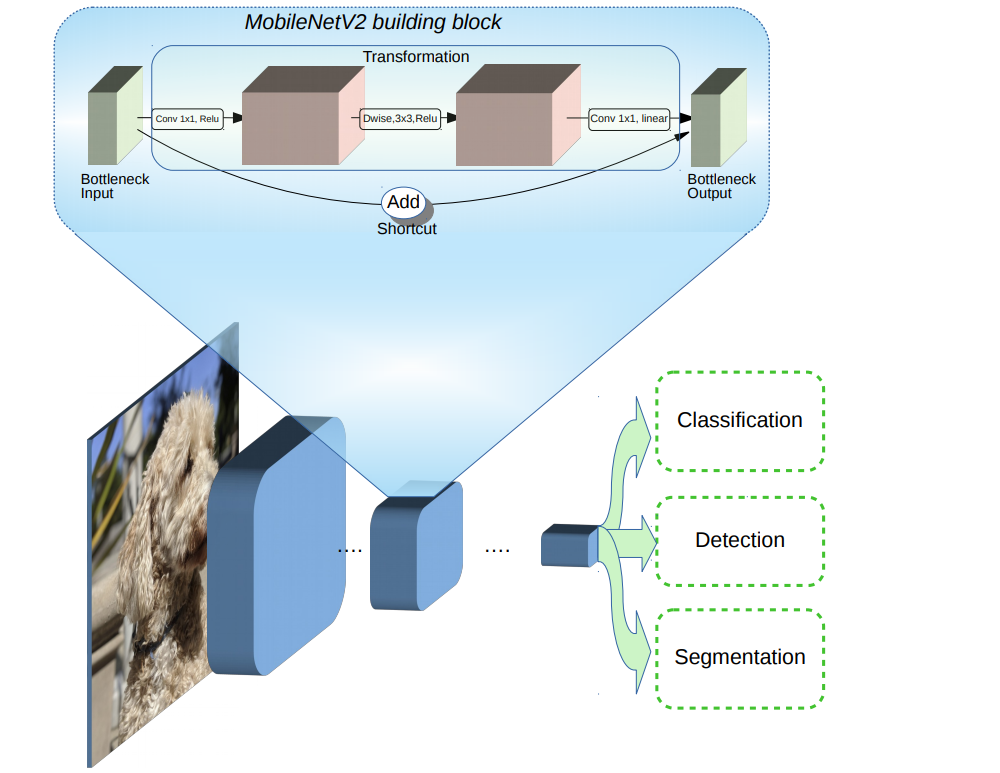

Here is an article explaining the significance of light weight models such as the MobileNet and MobileNetV2

>Link : - https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c

In [ ]:
## Getting the Pretrained model
mobnet_base_3 = tf.keras.applications.MobileNetV2(weights='imagenet', 
                  include_top=False, 
                  input_shape=(160 , 160, 3)) 

9420800/9406464 [==============================] - 0s 0us/step


**Note**
 
 We get a warning as:-
 
 >_WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default._

Hence I am using 160x 160 size

In [ ]:
mobnet_base_3.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### **Architecture**

In [ ]:
## Define our architecture
model_3 = models.Sequential()
model_3.add(mobnet_base_3)
model_3.add(layers.Flatten())
model_3.add(layers.Dense(256, activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(1, activation='sigmoid'))

### **Important Note on Experimentations**

I have tried models without drop out as part of my experimentation
1. Drop out after the flatten layer 
1. Drop out after the dense layer

The best accuracy was achieved when I did not have any dropouts, but this model was overfitting the training data**(train - 98%, Validation - 90%)**. But the model with dropout layer after the dense layer and before output layer had the closest accuracy on train and validation. This will be seen below.

In [ ]:
print('This is the number of trainable weights '
      'before freezing the mobnet base:', len(model_3.trainable_weights))
mobnet_base_3.trainable = False
print('This is the number of trainable weights '
      'after freezing the mobnet base:', len(model_3.trainable_weights))

This is the number of trainable weights before freezing the mobnet base: 160
This is the number of trainable weights after freezing the mobnet base: 4


In [ ]:
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 32000)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               8192256   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 10,450,497
Trainable params: 8,192,513
Non-trainable params: 2,257,984
___________________________________

### **Compile**

In [ ]:
model_3.compile(loss='binary_crossentropy', # Since 2 classes
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

### **Data preprocessing with Data Augmentation**

Data augmentation is a technique that uses transformations like image rotation, scaling, shearing to increate the diversity of your training set. This is not considered as data duplication because even thought the Images have the same information, their numpy arrays will be different. For examply, if we rotate an image of a cat by 90 degrees, it'll still be an image of a cat. But, the numpy arrays of this image are now the transpose of our original image and hence we can consider them to be a completely different data point.  In this project, I will try to use the augumentation through rotation, flipping, zooming, and shifting of the image. In data-constrained contexts, data augmentation is an efficient way to increase the performance and accuracy of models.


In [ ]:
# Data Augmentation
train_datagen_3 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Note that the validation data should not be augmented!
# we simply scale it by the max value (255)
test_datagen_3 = ImageDataGenerator(rescale=1./255)

train_generator_3 = train_datagen_3.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 160x160
        target_size=(160, 160),
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator_3 = test_datagen_3.flow_from_directory(
        validation_dir,
        target_size=(160, 160),
        batch_size=10,
        class_mode='binary')

test_generator_3 = test_datagen_3.flow_from_directory(
        test_dir,
        target_size=(160, 160),
        batch_size=10,
        class_mode='binary')

Found 700 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


#### _**Lets see our Augmentations**_

In [ ]:
# We pick one image to "augment"
# this was defined above
img_path = train_dir + '/Healthy/Healthy_5.jpg'

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen_2.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

### **Fit Model**

In [ ]:
es = EarlyStopping(monitor='val_acc', mode='max', 
                   patience=10, 
                   verbose=1,
                   restore_best_weights=True)

history_3 = model_3.fit(
      train_generator_3,
      steps_per_epoch=70, # this will take batches of size 10
      epochs=100, 
      callbacks= [es],
      validation_data=validation_generator_3,
      validation_steps=20, # same, batches of size 10
      verbose=1)

Epoch 1/100
70/70 [==============================] - 40s 505ms/step - loss: 0.8098 - acc: 0.7043 - val_loss: 0.4384 - val_acc: 0.8300
Epoch 2/100
70/70 [==============================] - 32s 454ms/step - loss: 0.5566 - acc: 0.7771 - val_loss: 0.3610 - val_acc: 0.8650
Epoch 3/100
70/70 [==============================] - 30s 435ms/step - loss: 0.4661 - acc: 0.8214 - val_loss: 0.3755 - val_acc: 0.8350
Epoch 4/100
70/70 [==============================] - 38s 550ms/step - loss: 0.4284 - acc: 0.8429 - val_loss: 0.3160 - val_acc: 0.8700
Epoch 5/100
70/70 [==============================] - 37s 524ms/step - loss: 0.3549 - acc: 0.8600 - val_loss: 0.4445 - val_acc: 0.8150
Epoch 6/100
70/70 [==============================] - 32s 456ms/step - loss: 0.3110 - acc: 0.8757 - val_loss: 0.3289 - val_acc: 0.8800
Epoch 7/100
70/70 [==============================] - 31s 447ms/step - loss: 0.3026 - acc: 0.8814 - val_loss: 0.4123 - val_acc: 0.8650
Epoch 8/100
70/70 [==============================] - 32s 455ms

### **Evaluation Metrics** 

#### **Learning Curves**

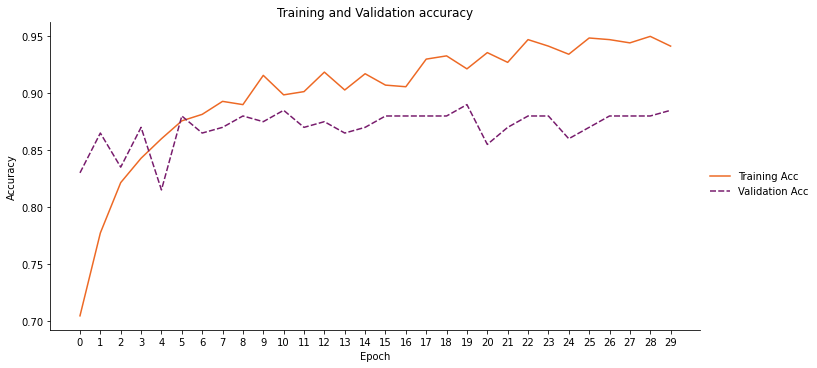

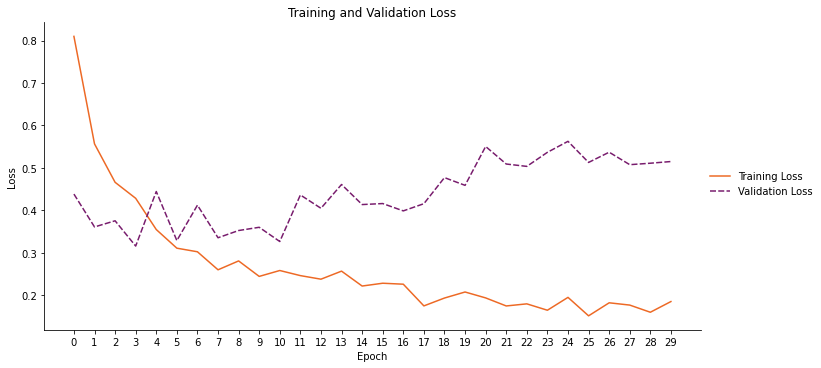

In [ ]:
learning_curves(history_3)

>The accuracy for both training and validation is close to each other as we train for more epochs indicating our model is not overfitting the training data. I have tried the same model with a dropout layer but there was a significant divergence between the accuracy curve.

#### **Confusion Matrix**

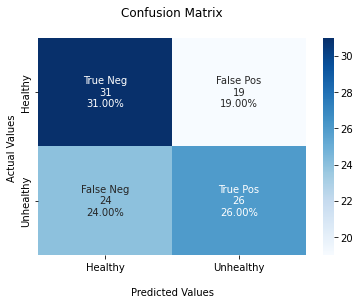


               precision    recall  f1-score   support

     Healthy       0.56      0.62      0.59        50
   Unhealthy       0.58      0.52      0.55        50

    accuracy                           0.57       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.57      0.57      0.57       100



In [ ]:
evaluation_metric_gen(model_3,test_generator_3)

>The confusion matrix is significantly better than our previous model. The recall now has bumped up to a 52% which is great but not the best. There are definitely ways to improve this by changing the threshholds of our model. Currently we have it at 0.5 so any prediction of less than 0.5 will mean a classification as healthy house plant. If we want to reduce our False Negatives, we will have to reduce our cutoff to maybe 0.4 to bump up our recall for unhealthy plants.

>Important thing to note that the accuracy here is based on precision and recall and the accuracy while fitting is actually the Root Mean Square Error

In [ ]:
test_loss_3, test_acc_3 = model_3.evaluate(test_generator_3, steps=10)
test_acc_3 = round(test_acc_3,5)
val_acc_3  = round(max(history_3.history['val_acc']),5)

10/10 [==============================] - 2s 233ms/step - loss: 0.1932 - acc: 0.9500


In [ ]:
print('Validation Accuracy: %s  \nTest Accuracy: %s' % (val_acc_3,test_acc_3))

Validation Accuracy: 0.89  
Test Accuracy: 0.95


>We are getting better test accuracy(mse) for the MobNet model

## **Setup for Real-Time Classification**

I am saving the weights we learnt for plants health classification usecase. These weights will be made available as an h5 file if anyone wants to leverage it.

In the next part we will be loading this model and start to play with its realtime application

In [ ]:
# Save Model
model_3.save('/content/drive/Your Path/model_3.h5')